In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

In [3]:
target = 'l 98-59'
tpf = lightkurve.search_targetpixelfile(target).download()


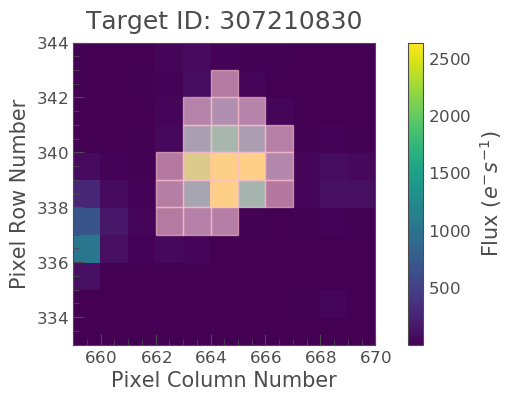

In [4]:
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (tpf.time.min() + tpf.time.max())
flux = tpf.flux

pix_mask = tpf.create_threshold_mask(threshold=3)
tpf.plot(aperture_mask=pix_mask, )


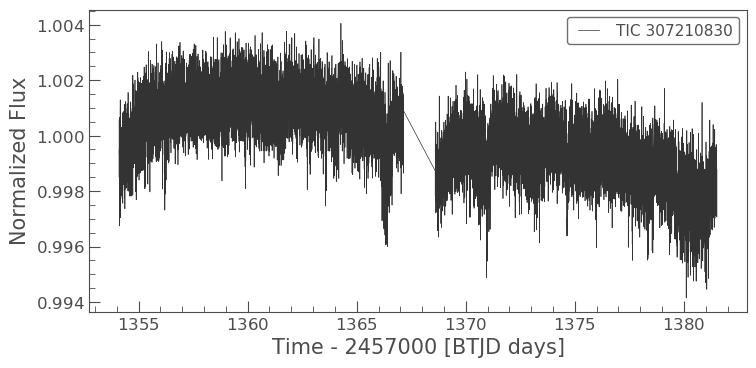

In [5]:
lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc = lc.normalize()
lc.plot()
lc.flux = (lc.flux - 1.0) * 1e3

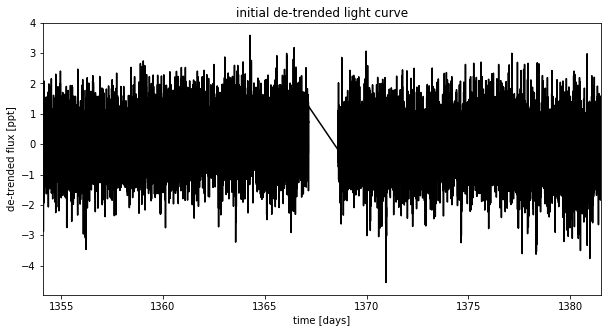

In [6]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [7]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.03

bls_periods = np.zeros([3])
bls_t0s = np.zeros([3])
bls_depths = np.zeros([3])
time = lc.time - ref_time

# planet 1
bls = BoxLeastSquares(time, lc.flux - pld_flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask] - pld_flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth

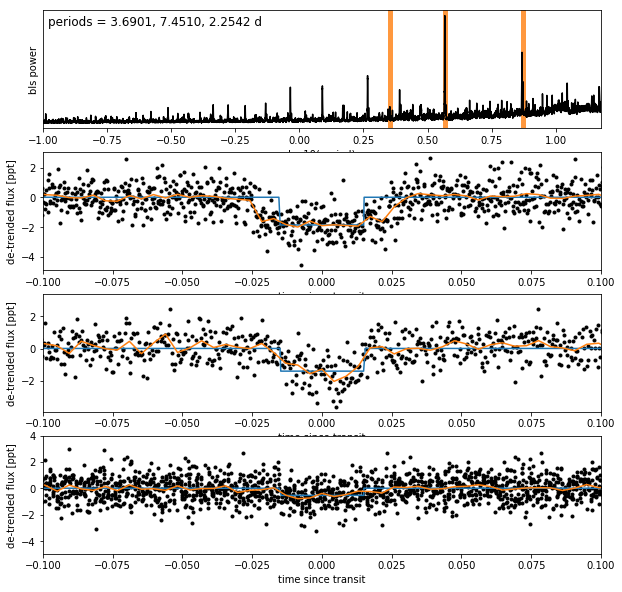

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transits
bls = BoxLeastSquares(time, lc.flux - pld_flux)
for i in range(3):
    ax = axes[i+1]
    x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], lc.flux[m] - pld_flux[m], ".k")
    inds = np.argsort(x_fold[m])
    ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

    # Overplot the phase binned light curve
    bins = np.linspace(-0.11, 0.11, 52)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=lc.flux - pld_flux)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.1, 0.1)
    ax.set_ylabel("de-trended flux [ppt]")
    ax.set_xlabel("time since transit");


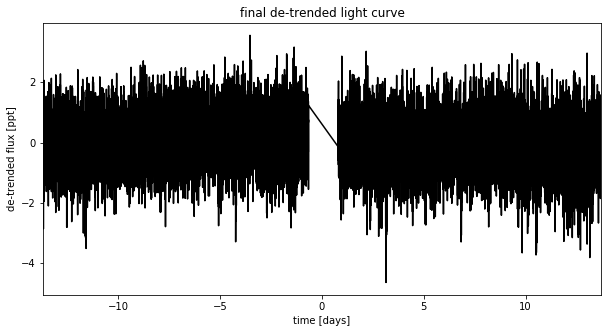

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(x.min(), x.max());

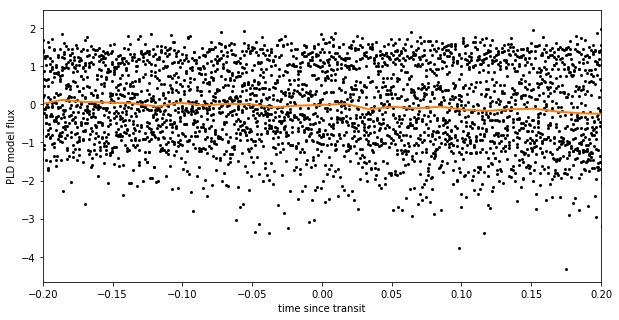

In [10]:
plt.figure(figsize=(10, 5))

x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.3
plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

bins = np.linspace(-0.5, 0.5, 60)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=pld_flux)
denom[num == 0] = 1.0
plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
plt.xlim(-0.2, 0.2)
plt.xlabel("time since transit")
plt.ylabel("PLD model flux");

In [11]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0, 2.0
#         m_star = pm.Normal("m_star", mu=M_star_kostov[0], sd=M_star_kostov[1])
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        rho_star = pm.Normal("rho_star", mu=Rho_star_kostov[0], sd=Rho_star_kostov[1])

        # Prior to require physical parameters
#         pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=1, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=1, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=1, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.01, max_radius=0.3,
#             testval_r=np.sqrt(1e-3)*np.sqrt(bls_depths),
#             testval_b=[0.1,0.8,0.1])
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.01, shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        
        # Log-uniform prior on ror
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
#         pm.Potential("ror_prior", -tt.log(ror))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logS0 = pm.Normal("logS0", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        
        a = pm.Deterministic("a", orbit.a)
#         pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve - mean))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[logs2, logS0, logw0])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidime

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


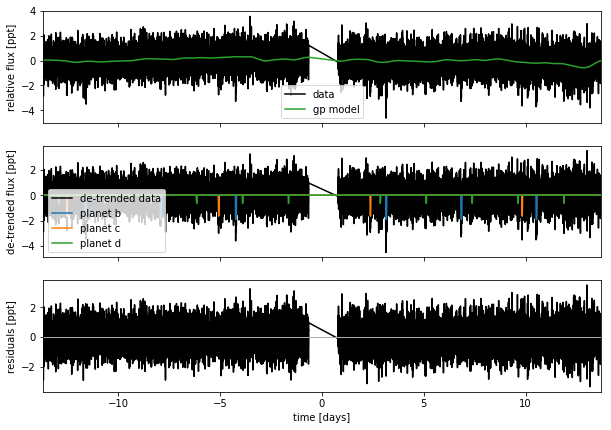

In [12]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.gp_pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

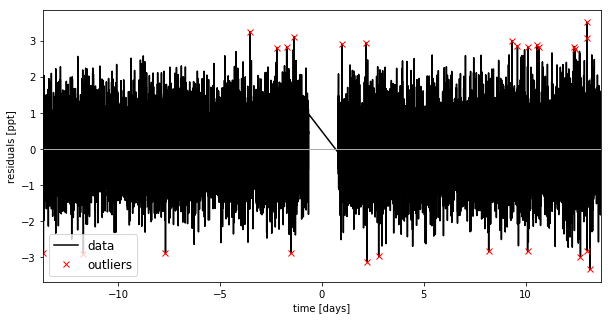

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -22,432, ||grad|| = 0.62608: 100%|██████████| 24/24 [00:00<00:00, 91.31it/s]  
INFO (theano.gof.compilelock): Waiting for existing lock by process '3455' (I am process '3498')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/tom/.theano/compiledir_Linux-4.15--generic-x86_64-with-debian-buster-sid-x86_64-3.7.1-64/lock_dir
logp = -22,431, ||grad|| = 0.63159: 100%|██████████| 14/14 [00:00<00:00, 96.02it/s]  
logp = -22,431, ||grad|| = 176.41: 100%|██████████| 23/23 [00:00<00:00, 74.49it/s]   


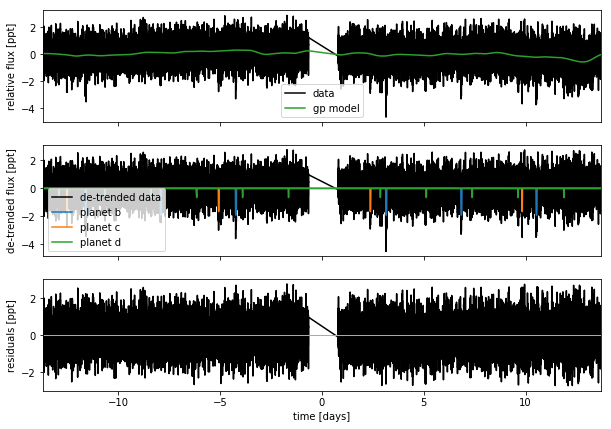

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(model, map_soln, mask);

In [15]:
sampler = xo.PyMC3Sampler(window=100, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 808/808 [21:29<00:00,  4.93s/draws]
The chain contains only diverging samples. The model is probably misspecified.


In [16]:
with model:
    trace = sampler.sample(draws=2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logw0, logS0, logs2, omega, ecc, b_param, logror, t0, logP, rho_star, r_star, u_star, mean]
Sampling 4 chains: 100%|██████████| 8000/8000 [38:03<00:00,  1.24draws/s]  
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.46204545643532663, but should be close to 0.9. Try to increase the number of tuning steps.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.22410555425315773, but should be close to 0.9. Try to increase the number of tuning steps.
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4343731660297574, but should be close to 0.9. Try to increase the number of tuning steps.
There were 265 divergences after tuning. Increase `target_accept` or re

In [18]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", 
                            "ecc", "b", "r_pl", "t0", "period", "r_star", "rho_star", "u_star", "mean"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logw0,0.466263,0.195584,0.008580,0.135177,0.878571,104.361085,1.016391
logS0,-3.347696,0.502169,0.026589,-4.315513,-2.517790,49.641655,1.026358
logs2,-0.392309,0.009576,0.000264,-0.412040,-0.372685,1185.953826,1.001062
omega__0,-0.887531,1.422054,0.046362,-3.137161,2.341982,716.340952,1.006315
omega__1,-0.014312,1.731661,0.073775,-2.773836,3.134188,70.302750,1.028844
omega__2,-0.035451,1.930842,0.110295,-3.057508,2.909653,26.464976,1.063400
ecc__0,0.182823,0.160633,0.012334,0.000018,0.540349,16.612143,1.108515
ecc__1,0.256505,0.242229,0.018565,0.002553,0.773582,13.485019,1.153866
ecc__2,0.148108,0.146290,0.008803,0.000135,0.448433,22.965386,1.085583
b__0,0.299691,0.192337,0.012885,0.016926,0.678470,20.990546,1.092061


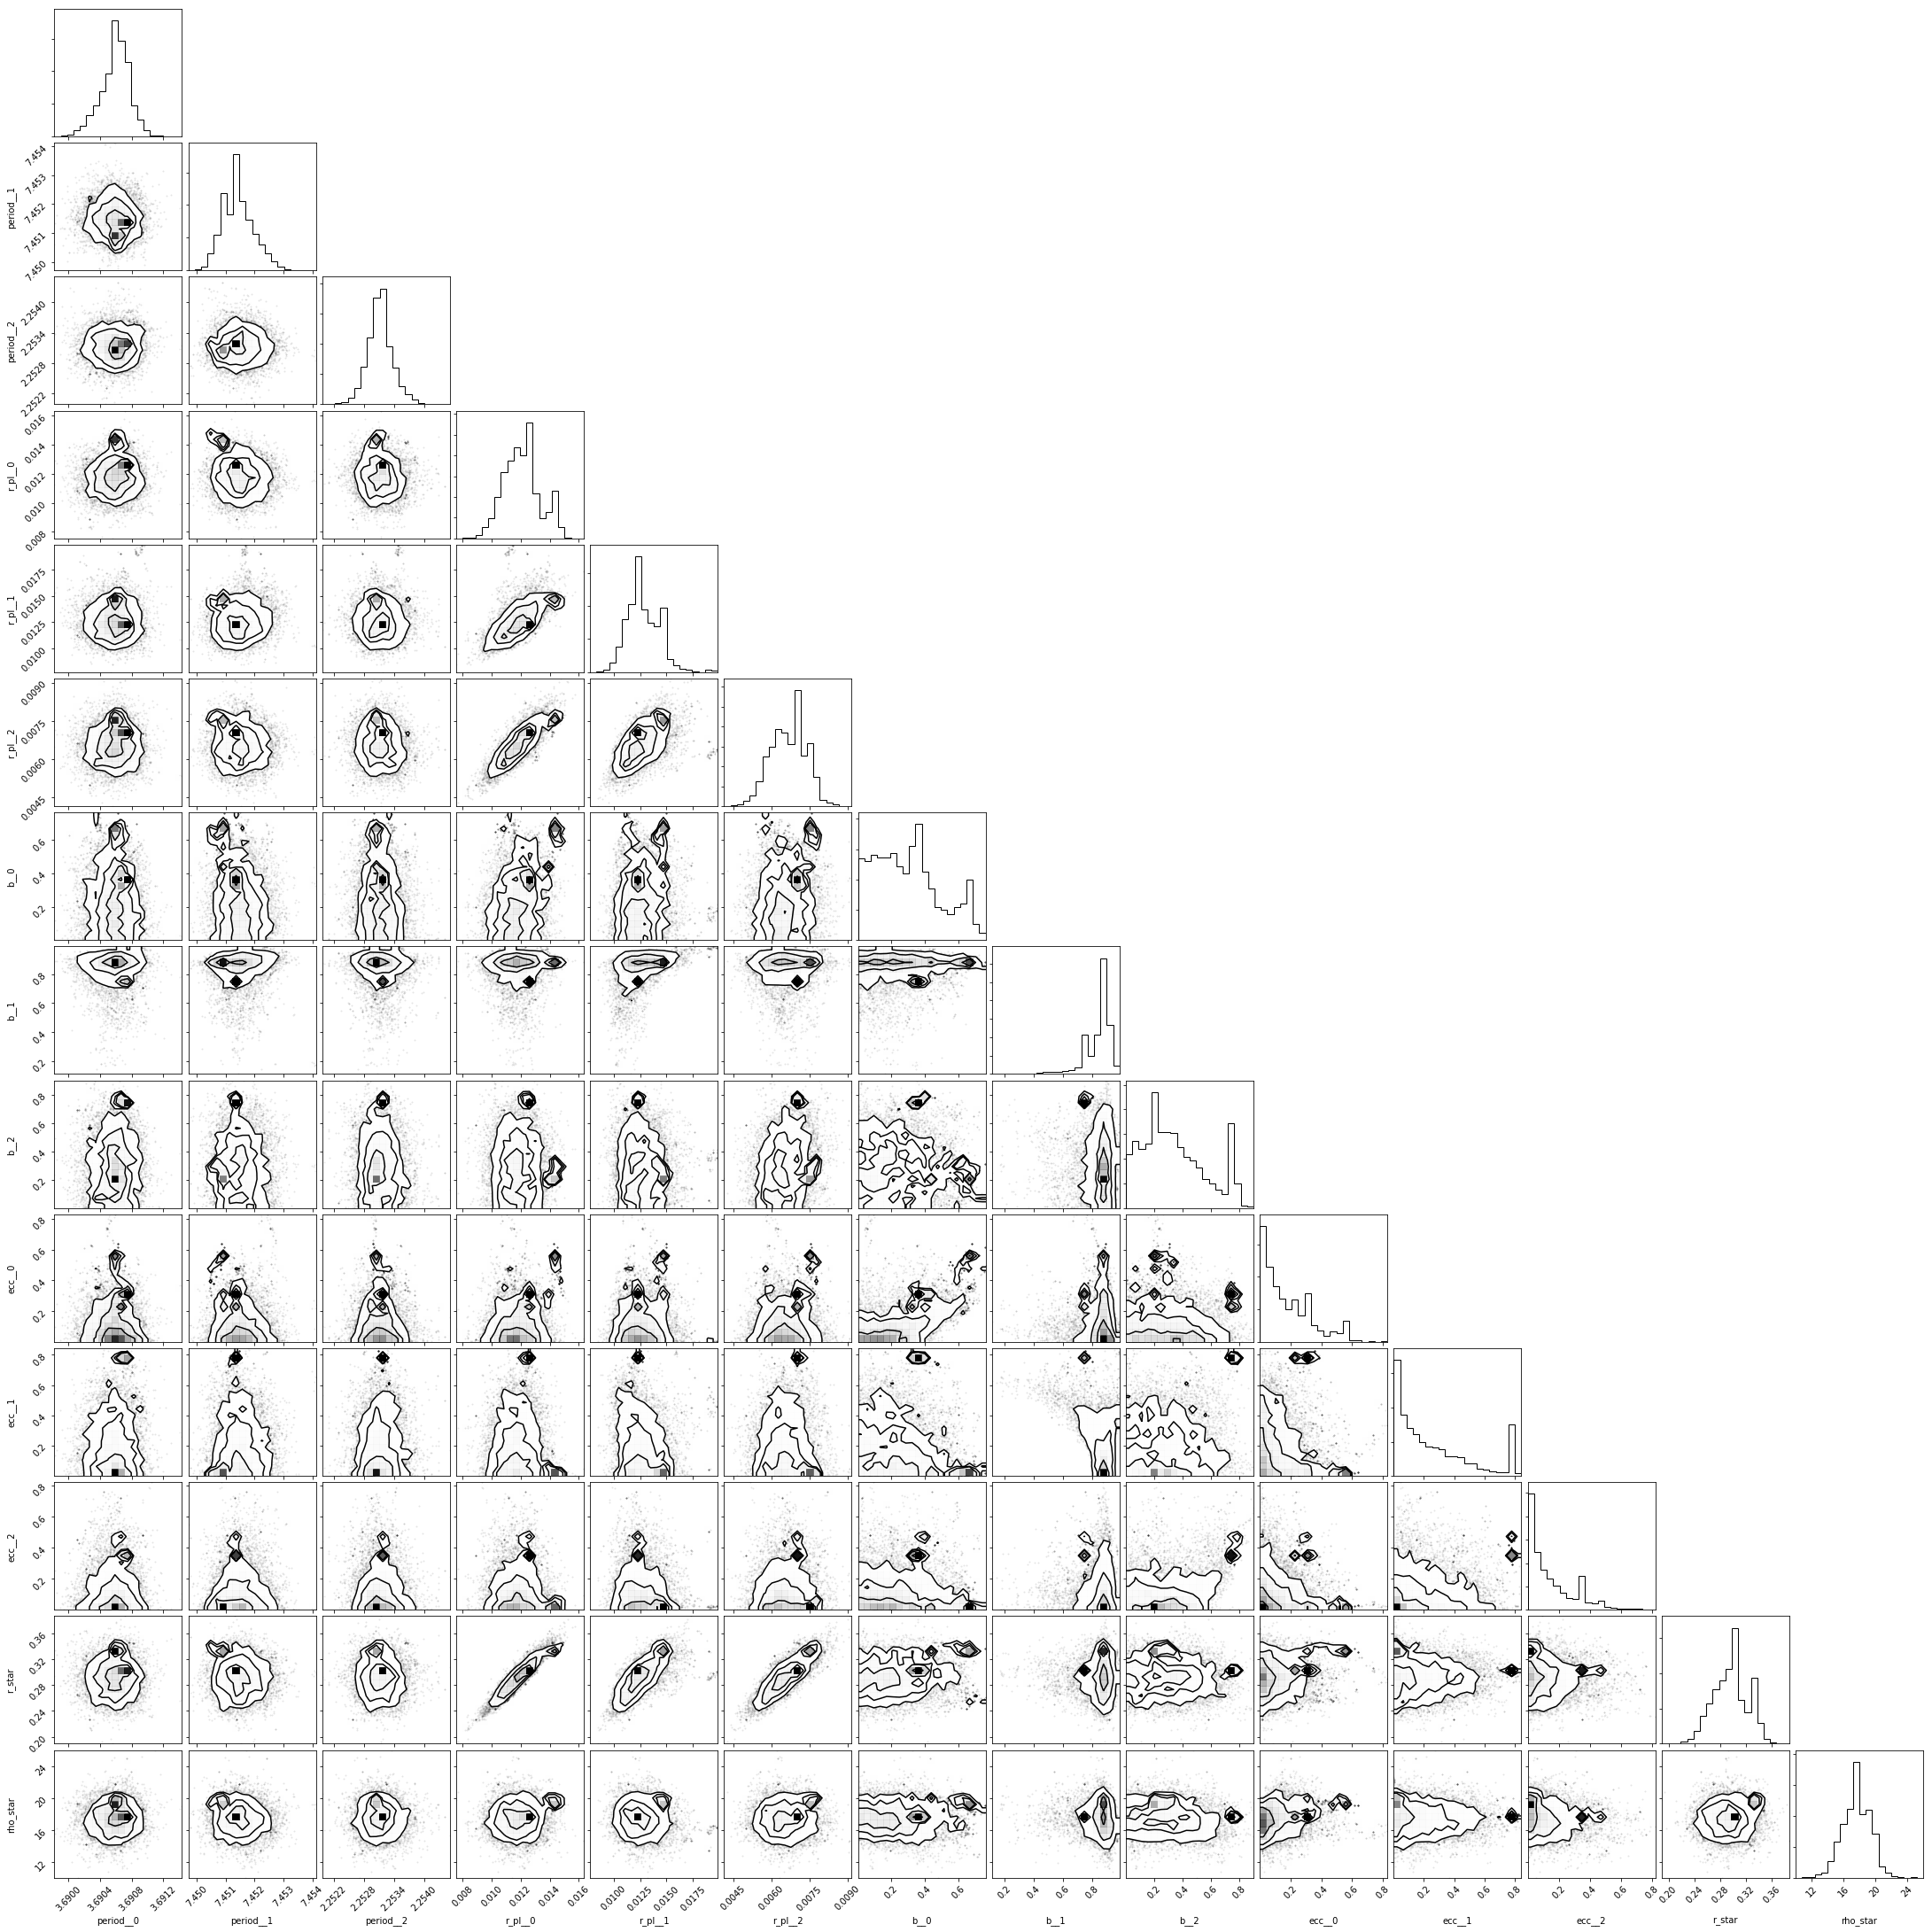

In [23]:
import corner
varnames = ["period", "r_pl", "b", "ecc", "r_star", "rho_star"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);



In [25]:
xo.citations.get_citations_for_model(model)

('This research made use of \\textsf{exoplanet} \\citep{exoplanet} and its\ndependencies \\citep{exoplanet:astropy13, exoplanet:astropy18,\nexoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,\nexoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.',
 '\n@misc{exoplanet:exoplanet,\n    title={exoplanet v0.1.2},\n   author={Foreman-Mackey, Daniel},\n    month={dec},\n     year={2018},\n      doi={10.5281/zenodo.2536576},\n      url={https://doi.org/10.5281/zenodo.2536576}\n}\n\n\n@article{exoplanet:pymc3,\n    title={Probabilistic programming in Python using PyMC3},\n   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},\n  journal={PeerJ Computer Science},\n   volume={2},\n    pages={e55},\n     year={2016},\npublisher={PeerJ Inc.}\n}\n\n\n@article{exoplanet:theano,\n    title="{Theano: A {Python} framework for fast computation of mathematical\n            expressions}",\n   author={{Theano Development Team}},\n  journal